In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision = 3, suppress = True)

### Параметри для генерування часового ряду

In [2]:
gen_order = (3, 3)          # порядок моделі
a = [0, 0.22, -0.18, 0.08]  # коефіцієнти АР
b = [0.5, 0.25, 0.25]       # коефіцієнти КС
N = 100                     # кількість згенерованих значень

### Функція для генерування часового ряду

In [3]:
def make_series(a_coef, b_coef, order, n, mov_avg, noise_std = 0):
    y = [0]*order[0]
    for k in range(n):
        y.append(
            a_coef[0] +
            sum([a_coef[j]*y[order[0]+k-j] for j in range(1, order[0]+1)]) +
            mov_avg[order[1]+k] + 
            sum([b_coef[j-1]*mov_avg[order[1]+k-j] for j in range(1, order[1]+1)]) +
            np.random.randn()*noise_std
        )
    return np.array(y[order[0]:])

### Власне генерування часового ряду та його візуалізація

In [4]:
np.random.seed(42)
v = np.random.randn(N+gen_order[1])
y = make_series(a_coef = a, b_coef = b, 
                order = gen_order, n = N,
                mov_avg = v, noise_std = 0.5)

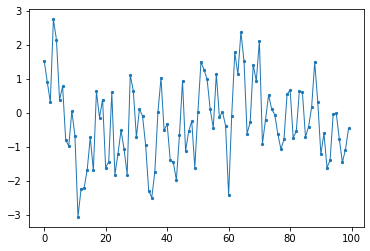

In [5]:
plt.plot(y, lw = 1)
plt.scatter(np.arange(N), y, s = 5)

### Функція для створення матриці спостережень X

In [6]:
def create_X(y, v, ARMA = (3, 3)):
    N = min(len(y)-ARMA[0], len(v)-ARMA[1])
    X = np.zeros((N, 2+ARMA[0]+ARMA[1]))
    X[:, 0] = np.ones((N, ))
    for j in range(ARMA[0]):
        X[:, ARMA[0]-j] = y[j:N+j]
    for j in range(ARMA[1]+1):
        X[:, ARMA[0]+ARMA[1]-j+1] = v[j:N+j]
    return X

### МНК

In [7]:
def LS(X, y):
    coefs_history = []
    for i in range(len(y)):
        X_temp = X[:i+1]
        y_temp = y[:i+1]
        coefs_history.append(
            np.linalg.pinv(X_temp.T @ X_temp) @ X_temp.T @ y_temp
        )
    return coefs_history

### РМНК

In [8]:
def RLS(X, y):
    n = X.shape[1]
    theta = np.zeros((n, 1))
    coefs_history = [theta.flatten()]
    P = 1e5 * np.eye(n)
    for i in range(len(y)):
        x = X[i].reshape((n, 1))
        temp = P @ x / (1 + x.T @ P @ x)
        theta += temp * (y[i] - x.T @ theta)
        coefs_history.append(theta.flatten())
        P = P - temp @ x.T @ P
    return coefs_history

### Функції для обчислення метрик моделі

In [9]:
# сума квадратів похибок
def sum_squared_error(y_true, y_pred):
    return ((y_true - y_pred)**2).sum()

# коефіцієнт детермінації R^2
def r_squared(y_true, y_pred):
    return y_pred.var() / y_true.var()

# значення критерію Акайке
def akaike(y_true, y_pred, ARMA):
    n = ARMA[0] + ARMA[1] +1
    N = y_true.size 
    return N * np.log(sum_squared_error(y_true,y_pred)) + 2*n

### Задання порядку моделі, яка буде шукатися

In [10]:
ARMA = (1, 1)

### Створення матриці X та вигляд її перших 5 рядків

In [11]:
X = create_X(y, v[gen_order[1]:], ARMA)

In [12]:
X[:5]

array([[ 1.   ,  1.535, -0.234,  1.523],
       [ 1.   ,  0.912, -0.234, -0.234],
       [ 1.   ,  0.318,  1.579, -0.234],
       [ 1.   ,  2.756,  0.767,  1.579],
       [ 1.   ,  2.149, -0.469,  0.767]])

### Знаходження коефіцієнтів за допомогою МНК та їх оцінювання

In [13]:
LS_history = LS(X, y[gen_order[0]:])
res_LS = LS_history[-1]
res_LS[ARMA[1]+1] = 1

In [14]:
res_LS

array([-0.213,  0.181,  1.   ,  0.006])

In [15]:
y_LS = make_series(a_coef = res_LS[:ARMA[0]+1], b_coef = res_LS[ARMA[0]+2:], 
                order = ARMA, n = N, mov_avg = v)

In [16]:
print('S =', sum_squared_error(y, y_LS))
print('R^2 =', r_squared(y, y_LS))
print('IKA =', akaike(y, y_LS, ARMA))

S = 182.94330686858663
R^2 = 0.6201883407989879
IKA = 526.9176306311629


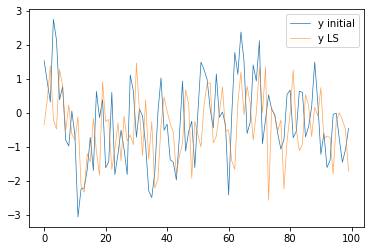

In [17]:
plt.plot(y, label = 'y initial', lw = 0.7)
plt.plot(y_LS, label = 'y LS', lw = 0.7, alpha = 0.7)
plt.legend()

### Знаходження коефіцієнтів за допомогою РМНК та їх оцінювання

In [18]:
RLS_history = RLS(X, y[gen_order[0]:])
res_RLS = RLS_history[-1]
res_RLS[ARMA[1]+1] = 1

In [19]:
res_RLS

array([-0.213,  0.181,  1.   ,  0.006])

In [20]:
y_RLS = make_series(a_coef = res_RLS[:ARMA[0]+1], b_coef = res_RLS[ARMA[0]+2:], 
                order = ARMA, n = N, mov_avg = v)

In [21]:
print('S =', sum_squared_error(y, y_RLS))
print('R^2 =', r_squared(y, y_RLS))
print('IKA =', akaike(y, y_RLS, ARMA))

S = 182.94330611468996
R^2 = 0.6201883406451515
IKA = 526.9176302190699


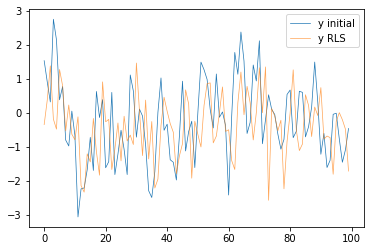

In [22]:
plt.plot(y, label = 'y initial', lw = 0.7)
plt.plot(y_RLS, label = 'y RLS', lw = 0.7, alpha = 0.7)
plt.legend()